This IPython Notebook shows how to visualize the data created by the ZEN Image Analysis using the Zone Of Influence (ZOI) segmentation.
Typical Applications for ZOI are in cell biology, drug discovery, in-vitro assays, endpoint assays, e.g.:

* Cytoplasm-Nucleus Translocation
* Protein Localization
* Count sub-objects inside and outside of the primary object (e.g. vesicles, PML bodies,…)

<img src="Tutorial\ZOI_Applications.png" />

**For further details please see:**
    
[ZOI Tutorial.pdf]('Tutorial\ZOI - Tutorial.pdf')

**Application Example: Translocation Assay**

<img src="Tutorial\ZOI_Translocation.png" />

**Human U2OS cells cytoplasm–nucleus translocation**

* 96-well plate, human osteosarcoma cells (U2OS), nuclei stained with DRAQ
* Cytoplasm to nucleus translocation of the Forkhead (FKHR-EGFP) fusion protein
* In proliferating cells, FKHR is localized in the cytoplasm (constantly moving into the nucleus, but is transported out again by export proteins). 
* Upon inhibition of nuclear export, FKHR accumulates in the nucleus
* Export is inhibited by blocking PI3 kinase / PKB with <span style="color:green"> *Wortmannin*</span> or <span style="color:orange">*LY294002*</span>.


<img src="Tutorial\ZOI_U2OS.png" />


Data set [BBBC013v1](https://data.broadinstitute.org/bbbc/BBBC013/) by Ilya Ravkin, available from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012](http://dx.doi.org/10.1038/nmeth.2083)

In [1]:
# do the required imports
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
from plotly.graph_objs import *
sys.path.append(r'Modules')
import wellplate_tools_pandas as wpt

In [2]:
# load the data file created by ZEN Blue ZOI image analysis
#filename_single = r'Data\_Primary Object.csv'
#filename_single = r'Data\Translocation_comb_96_5ms Region Primary Object ZEN2.6.csv'
filename_single = r'Data\_Primary Object Translocation_2 ZEN 25.csv'

zoi_transloc = True

# check the used separator
sep = wpt.check_separator(filename_single)

# read the CSV table containing all the single object data
df_single = pd.read_csv(filename_single, sep=sep)

# get headers and number of measurement parameters
headers = df_single.head(0)

# define wellplate type (this has to be done by user)
platetype = 96

# get numer of rows and columns
Nr, Nc = wpt.getrowandcolumn(platetype)

In [3]:
# default number of non-measurement parameters, e.g. IDs etc.
num_nonmp = 6

# list for renaming the parameters - please check your input CSV is the respective columns
# (might have different names) exits and if their order is reflected inside the parameterlist

if zoi_transloc:
    parameterlist = ['ParentID',    # ParentID::ID of the parent!!I
                     'ID',          # ID::ID!!I
                     'WellID',      # ImageSceneContainerName::Image Scene Container Name 
                     'RowID',       # ImageSceneRow::Image Scene Row Index!!I
                     'ColumnID',    # ImageSceneColumn::Image Scene Column Index!!I
                     'Index',       # Index::Index!!I
                     'Area',        # Area::Area!!R
                     'NucMeanDapi', # IntensityMean_DAPI::Intensity Mean Value of channel 'DAPI'!!R
                     'NucMeanGFP',  # IntensityMean_EGFP::Intensity Mean Value of channel 'EGFP'!!R
                     'RingMeanGFP', # CopyRingIntensityMean1::Ring Mean Intensity 1!!R
                     'RingArea']    # CopyRingArea::Ring Area!!R

elif not zoi_transloc:
    parameterlist = ['ParentID',    # ParentID::ID of the parent!!I
                     'ID',          # ID::ID!!I
                     'WellID',      # ImageSceneContainerName::Image Scene Container Name
                     'RowID',       # ImageSceneRow::Image Scene Row Index!!I
                     'ColumnID',    # ImageSceneColumn::Image Scene Column Index!!I
                     'Index']       # Index::Index!!I

In [4]:
# rename columns
df_single = wpt.rename_columns(df_single, parameterlist)

# remove rows with units from datafrane
df_single = wpt.remove_units(df_single)

# convert decimal separators to point "."
df_single = wpt.convert_dec_sep(df_single, num_nonmp)

**Human U2OS cells cytoplasm–nucleus translocation**

* Calculate the Translocation-Ratio (T) for each cell
* Calculate the mean value for each well 


<img src="Tutorial\ZOI_Ratio_Calculation.png" />

In [5]:
if zoi_transloc:

    # add another column and calculate the ratio between GFP in nucleus and GFP in Ring for the translocation assay
    df_single['Ratio'] =  df_single['NucMeanGFP']/df_single['RingMeanGFP']

    # replace infinity values with nan
    df_single = df_single.replace([np.inf, -np.inf], np.nan)

In [6]:
# calculate the number of actual measurment parameters for single objects
num_param = len(df_single.columns) - num_nonmp
print('Number of Object Parameters: ', num_param)

# show part of dataframe
df_single[:6]

Number of Object Parameters:  6


,ParentID,ID,WellID,RowID,ColumnID,Index,Area,NucMeanDapi,NucMeanGFP,RingMeanGFP,RingArea,Ratio
1,269.0,270.0,A1,1.0,1.0,1.0,2.64,133.337121,88.053030,141.167832,1.43,0.623747
2,271.0,272.0,A1,1.0,1.0,2.0,1.84,79.288043,0.000000,0.029630,1.35,0.000000
3,273.0,274.0,A1,1.0,1.0,3.0,3.04,168.177632,9.819079,9.220588,1.36,1.064908
4,275.0,276.0,A1,1.0,1.0,4.0,2.81,106.231317,38.793594,46.607143,1.96,0.832353
5,277.0,278.0,A1,1.0,1.0,5.0,2.47,146.546559,52.777328,65.034722,1.44,0.811525
6,279.0,280.0,A1,1.0,1.0,6.0,2.01,96.686567,33.407960,68.377778,1.35,0.488579


In [7]:
# use statistics for a wells to be displayed inside the heatmaps.
# currently implemented are mean, median, min, max.
stf = 'mean'

# create a dictionary containing a dataframe for every measured parameter
# as a heatmap and a dictionary containing the values for all wells containing actual data points.

heatmap_dict, well_dict = wpt.fill_heatmaps(df_single, num_param, num_nonmp, Nr, Nc,
                                            statfunc=stf,
                                            showbar=True,
                                            verbose=False,
                                            wellID_key='WellID',
                                            rowID_key='RowID',
                                            colID_key='ColumnID')

# show all keys
heatmap_dict.keys()

---------------------------------------------------
wellID_key :  WellID
Found keys:
Index(['ParentID', 'ID', 'WellID', 'RowID', 'ColumnID', 'Index', 'Area',
       'NucMeanDapi', 'NucMeanGFP', 'RingMeanGFP', 'RingArea', 'Ratio'],
      dtype='object')
---------------------------------------------------


FloatProgress(value=1.0, description='Processing Wells', max=96.0, min=1.0)

HeatMap:  Area
HeatMap:  NucMeanDapi
HeatMap:  NucMeanGFP
HeatMap:  RingMeanGFP
HeatMap:  RingArea
HeatMap:  Ratio
HeatMap:  ObjectNumbers


dict_keys(['Area', 'NucMeanDapi', 'NucMeanGFP', 'RingMeanGFP', 'RingArea', 'Ratio', 'ObjectNumbers'])

Heatmap image saved as:  Data\_Primary Object Translocation_2 ZEN 25_HM_ObjectNumbers.png


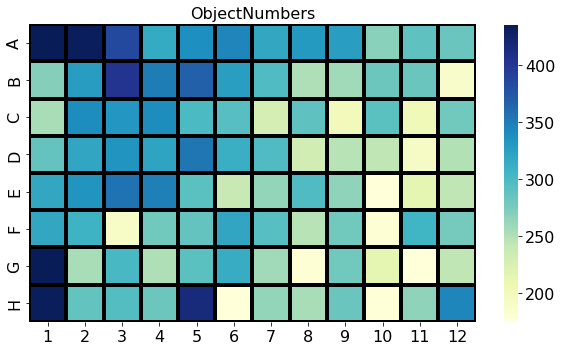

In [8]:
# define parameter to display a single heatmap
parameter2display = 'ObjectNumbers'
colormap ='YlGnBu'

# get the actual heatmap array to display it as an image from the dictionary
hm = heatmap_dict[parameter2display]

# show the heatmap for a single parameter
savename_single = wpt.showheatmap(hm, parameter2display,
                                  fontsize_title=16,
                                  fontsize_label=16,
                                  colormap=colormap,
                                  linecolor='black',
                                  linewidth=3.0,
                                  save=True,
                                  filename=filename_single,
                                  dpi=300)

Heatmap image saved as:  Data\_Primary Object Translocation_2 ZEN 25_HM_all.png


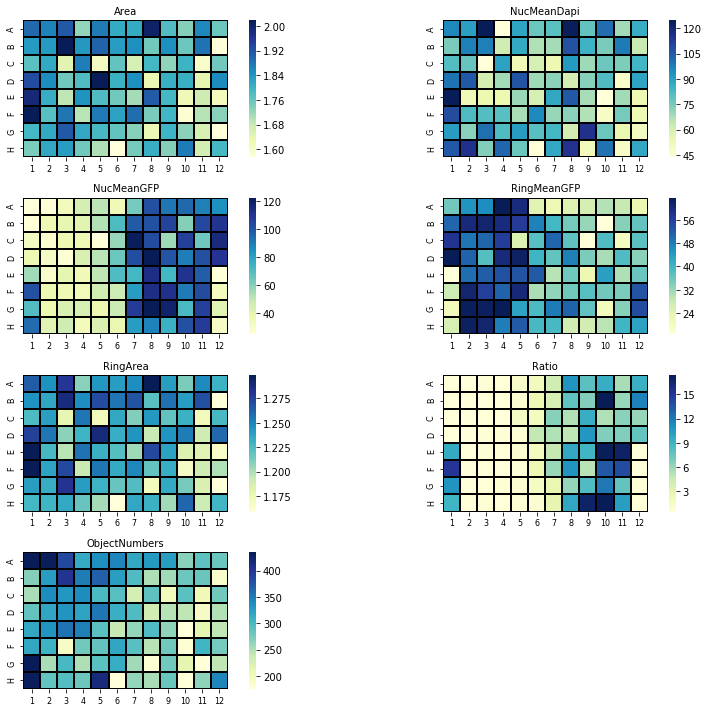

In [9]:
# define parameters to display the heatmap
colormap ='YlGnBu'

plotgrid, deletelastplot = wpt.determine_plotgrid(num_param + 1, columns=2)

# show all heatmaps
savename_all = wpt.showheatmap_all(heatmap_dict, plotgrid,
                                   fontsize_title=10,
                                   fontsize_label=8,
                                   colormap=colormap,
                                   linecolor='black',
                                   linewidth=1.0,
                                   save=True,
                                   filename=filename_single,
                                   deletelast=deletelastplot)

In [10]:
# show all key = measure parameters for that dictionary
print(heatmap_dict.keys())

# show example entry of the dictionary for a parameter
well_df = heatmap_dict[parameter2display]
rowlabel, collabel = wpt.extract_labels(Nr, Nc)

dict_keys(['Area', 'NucMeanDapi', 'NucMeanGFP', 'RingMeanGFP', 'RingArea', 'Ratio', 'ObjectNumbers'])


In [11]:
# example for entry for well ...
well_dict['F7']

WellID                F7
RowID                  6
ColumnID               7
Area              1.8898
NucMeanDapi      70.8404
NucMeanGFP       82.1646
RingMeanGFP      32.9049
RingArea         1.24939
Ratio            6.06149
ObjectNumbers        294
Name: 41, dtype: object

In [12]:
data = [go.Heatmap(z=hm.values.tolist(),
                   x=rowlabel,
                   y=collabel,
                   colorscale='Viridis'),
       ]

In [13]:
layout = go.Layout(title=parameter2display,
                   autosize = True,
                   xaxis = dict(#autotick=False,
                                title='Columns',
                                showgrid=True,
                                gridwidth=5,
                                #ticks=collabel,
                                #ticks='outside',
                                nticks=Nc,
                                scaleanchor='y',
                                scaleratio=0.1),
                   yaxis = dict(#autotick=False,
                                title='Rows',
                                showgrid=True,
                                gridwidth=5,
                                #ticks=collabel,
                                #ticks='inside',
                                nticks=Nr,
                                autorange='reversed',
                                scaleanchor='x',
                                scaleratio=0.1),
                  )

fig = go.Figure(data=data, layout=layout)

In [14]:
plotly.offline.init_notebook_mode(connected=True)
plotly.offline.iplot(fig, filename='basic-heatmap')

cd c:\Users\m1srh\OneDrive - Carl Zeiss AG\IPython_Notebooks\ZEN_Wellplate_Analysis_Pandas\

jupyter nbconvert ZEN_Wellplate_Analysis_Pandas_Translocation_Tutorial.ipynb --to slides --post serve

jupyter nbconvert ZEN_Wellplate_Analysis_Pandas_Translocation_Tutorial.ipynb --to slides --post serve 
--SlidesExporter.reveal_theme=serif 
--SlidesExporter.reveal_scroll=True 
--SlidesExporter.reveal_transition=none